In [45]:
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import cv2
import time
import torch
import imutils
import numpy as np
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
device

device(type='cuda')

In [48]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title
cd "/content/drive/MyDrive/correct"

In [ ]:
#@title
!unzip '/content/drive/MyDrive/correct_mask.zip'


In [ ]:
#@title
cd "/content/drive/MyDrive/incorrect"

In [ ]:
#@title
!unzip '/content/drive/MyDrive/uncorrect_mask.zip'

In [49]:
batch_size = 64
learning_rate = 1e-5
num_epochs = 10


In [ ]:
cd "/content/drive/MyDrive/FaceMaskDetection/cv_data/big_data"

/content/drive/.shortcut-targets-by-id/1hQ8_evpZeV1uH3dOdu1bur4coGdhjFKN/FaceMaskDetection/cv_data/big_data


In [50]:
data_dir = "/content/drive/MyDrive/FaceMaskDetection/cv_data/small_data/4"
# train_dir = os.path.join(data_dir, 'train/')
# test_dir = os.path.join(data_dir, 'test/')

transform = transforms.Compose([transforms.Resize(350), 
                                transforms.CenterCrop(224), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

dataset = datasets.ImageFolder(data_dir, transform = transform)
print(len(dataset))
print(dataset.classes)

1935
['correct', 'incorrect']


Label:  correct (0)


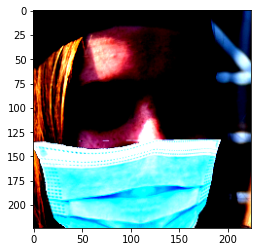

In [51]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))  

show_example(*dataset[234])


In [52]:
dataset[0][0].shape

torch.Size([3, 224, 224])

In [53]:
from torch.utils.data import random_split
val_pct = 0.1
val_size = int(val_pct * len(dataset))

train_data, valid_data = random_split(dataset, [len(dataset) - val_size, val_size])

In [54]:
print(f"No of Training Images: {len(train_data)},",
      f"No of Testing Images: {len(valid_data)}")

No of Training Images: 1742, No of Testing Images: 193


In [55]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                          shuffle = True)

In [34]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [57]:
model = models.resnet50(pretrained = True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [58]:
in_ft = model.fc.in_features
model.fc = nn.Linear(in_features=in_ft, out_features=2, bias = False)

In [59]:
model.load_state_dict(torch.load("/content/drive/MyDrive/FaceMaskDetection/models/mask_detection_model_3.pt"))


<All keys matched successfully>

In [60]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [61]:
device

device(type='cuda')

In [62]:
for i, child in enumerate(model.children()):
  if i <= 7:
     for params in child.parameters():
       params.requires_grad = False     
  print(i)

0
1
2
3
4
5
6
7
8
9


In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
)

In [64]:
def train_epoch(model, criterion, optimizer, train_loader):
  model.train()
  total_loss = 0
  total = 0
  for images, labels in tqdm(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    output = model(images)

    loss = criterion(output, labels)
    loss.backward()

    optimizer.step()
    total_loss += loss.item()
    total += len(labels)
  
  return total_loss/total

In [65]:
def valid_epoch(model, criterion, valid_loader):
  model.eval()
  total_loss = total = 0
  accuracy = 0
  eval_f1 = 0
  tmp = 0
  for batch_index, (images, labels) in tqdm(enumerate(valid_loader)):
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      output = model(images)
      loss = criterion(output, labels)

      output = output.detach().cpu().numpy()
      labels = labels.to('cpu').numpy()
      acc = flat_accuracy(output, labels)
      
      accuracy += acc
      # Record metrics
      total_loss += loss.item()
      total += len(labels)
      tmp += 1
    return total_loss / total, accuracy / tmp


In [67]:
train_losses, valid_losses = [], []
valid_acces = []
n_epochs = 0

for _ in range(num_epochs):
    train_loss = train_epoch(model,criterion, optimizer, train_dataloader)
    valid_loss, valid_acc = valid_epoch(model,criterion, valid_dataloader)
    
    # tqdm.write(
    #     f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.2e}'
    #     f'\tvalid_loss: {valid_loss:.2e}\n',
    #     f'\tvalid_loss: {valid_acc:.2e}\n',
    # )
    print("epoch:", " ", n_epochs)
    print("train_loss: ", " ", train_loss)
    print("valid_loss: ", " ", valid_loss)
    print("valid_acc: ", " ", valid_acc)
    # Early stopping if the current valid_loss is greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss >= loss
                                     for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    if len(valid_acces) == 0:
      torch.save(model.state_dict(), '/content/drive/MyDrive/FaceMaskDetection/models/mask_detection_model_4.pt')
    elif valid_acc > max(valid_acces):
      torch.save(model.state_dict(), '/content/drive/MyDrive/FaceMaskDetection/models/mask_detection_model_4.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_acces.append(valid_acc)
    n_epochs += 1

100%|██████████| 28/28 [00:52<00:00,  1.89s/it]
0it [00:03, ?it/s]


epoch:   0
train_loss:    0.0029187010072950106
valid_loss:    0.0022107893601059914
valid_acc:    0.96875


100%|██████████| 28/28 [00:50<00:00,  1.80s/it]
0it [00:02, ?it/s]


epoch:   1
train_loss:    0.0028943516544989137
valid_loss:    0.003548436099663377
valid_acc:    0.90625


100%|██████████| 28/28 [00:50<00:00,  1.80s/it]
0it [00:02, ?it/s]


epoch:   2
train_loss:    0.0029350676318260615
valid_loss:    0.002918139100074768
valid_acc:    0.921875


100%|██████████| 28/28 [00:50<00:00,  1.79s/it]
0it [00:02, ?it/s]


epoch:   3
train_loss:    0.002975179500510033
valid_loss:    0.0030842777341604233
valid_acc:    0.9375


100%|██████████| 28/28 [00:51<00:00,  1.84s/it]
0it [00:02, ?it/s]


epoch:   4
train_loss:    0.0029164888649049776
valid_loss:    0.0027377931401133537
valid_acc:    0.9375


100%|██████████| 28/28 [00:51<00:00,  1.83s/it]
0it [00:02, ?it/s]


epoch:   5
train_loss:    0.0029140639832044442
valid_loss:    0.002597837010398507
valid_acc:    0.96875


100%|██████████| 28/28 [00:50<00:00,  1.80s/it]
0it [00:01, ?it/s]


epoch:   6
train_loss:    0.0029717360106729885
valid_loss:    0.002594674238935113
valid_acc:    0.9375


100%|██████████| 28/28 [00:50<00:00,  1.80s/it]
0it [00:01, ?it/s]


epoch:   7
train_loss:    0.0028947248977922273
valid_loss:    0.002340847160667181
valid_acc:    0.953125


100%|██████████| 28/28 [00:51<00:00,  1.82s/it]
0it [00:03, ?it/s]

epoch:   8
train_loss:    0.002927137237260317
valid_loss:    0.003366500372067094
valid_acc:    0.90625
Stopping early


In [ ]:
from PIL import Image
def with_or_without_mask(image, model):
    input_img = Image.fromarray(image)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    
    input_tensor = preprocess(input_img)
    input_batch = input_tensor.unsqueeze(0)
    
    input_batch = input_batch.to(device)
        
    with torch.no_grad():
        output = model(input_batch)
        
    prob, index = torch.max(F.softmax(output[0]), 0)
    
    return prob, index

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/models/mask_detection_model.pt'))


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-7760f48bf20b>", line 1, in <module>
    model.load_state_dict(torch.load('/content/drive/MyDrive/models/mask_detection_model.pt'))
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 712, in load
    return _load(opened_zipfile, map_location, pickle_module, **pickle_load_args)
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 1049, in _load
    result = unpickler.load()
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 1019, in persistent_load
    load_tensor(dtype, nbytes, key, _maybe_decode_ascii(location))
  File "/usr/local/lib/python3.7/dist-packages/torch/serialization.py", line 1001, in load_tensor
    wrap_storage=restore_location(storage, location),
  File "/usr/local/lib/python3.7/d

RuntimeError: ignored

In [ ]:
def detect_and_predict(frame, faceNet, maskNet):
    # grab the dimension of the frame and then construct a blob from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
                                 (104.0, 177.0, 123.0))
    
    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    
    # initialize our list of faces, their corresponding locations
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []
    
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence associated with the detections
        confidence = detections[0, 0, i, 2]
        
        # filter out weak detections by ensuring the confidence greater than
        # the minimum confidence
        if confidence > 0.7:
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype('int')
            
            # ensure the bounding boxex fall within the dimension of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            
            # extract the face ROI and preprocess and predict
            face = frame[startY:endY, startX:endX]
            faces.append(face)
            locs.append((startX, startY, endX, endY))
            
    # only make a predictions if atleast one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on all the
        # faces at the same time rather than one-by-one prediction
        # in the above for loop
        for face in faces:
            pred = with_or_without_mask(face, maskNet)
            preds.append(pred)
    return (locs, preds)

In [ ]:
# import cv2_imshow
prototxtPath = '/content/drive/MyDrive/deploy.prototxt'
weightsPath = '/content/drive/MyDrive/res10_300x300_ssd_iter_140000.caffemodel'

faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
model.load_state_dict(torch.load('/content/drive/MyDrive/models/mask_detection_model.pt'))

# Starting video stream
vs = cv2.VideoCapture(0)
# vs = cv2.VideoCapture(0)
# time.sleep(2.0)

# loop over the frames from the video stream
while True:
    
    # grab the frame from the threaded video stram and resize to have a
    # minimum of 400 px
    _, frame = vs.read()
#     frame = imutils.resize(frame, width=400)
    
    # detect faces in the frame and determine if they are wearing
    # a face mask or not
    # (locs, preds) = detect_and_predict(frame, faceNet, model)
    
    # # loop over the detected face locations and their corresponding locations
    # for (box, pred) in zip(locs, preds):
    #     (startX, startY, endX, endY) = box
    #     (prob, clas) = pred
        
    #     # determine the class label and color we'll use to draw
    #     # the bounding box and text
    #     label = "Mask" if clas == 0 else "No Mask"
    #     color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        
    #     # include the probability in the label
    #     label = "{}: {:.2f}%".format(label, prob * 100)
        
    #     # display the label and bounding box rectangle on the original frame
    #     cv2.putText(frame, label, (startX, startY - 10),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    #     cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
    
    # show the output frame
    # cv2.imshow('Frame', frame)
    key = cv2.waitKey(1) & 0xFF
    
    # if the `q` key is pressed, break from the loop
    if key == ord("q"):
        break
# do a bit of cleanup
cv2.destroyAllWindows()
vs.release()

KeyboardInterrupt: ignored